# Table Comparison POC: Multiple Similarity Methods

This notebook demonstrates various methods for comparing tables and finding similarities between columns:

1. **Embedding-based comparison** - Using sentence transformers for semantic similarity
2. **Phonetic comparison** - Using Soundex, Metaphone for sound-alike matching
3. **Fuzzy logic comparison** - Using Levenshtein distance, Jaro-Winkler similarity
4. **Exact matching** - Direct string/value comparison
5. **Numeric similarity** - Statistical measures for numerical data
6. **Date/temporal comparison** - Time-based similarity measures

## Use Cases:
- Data deduplication and record linkage
- Table schema matching
- Data quality assessment
- Entity resolution across datasets

In [1]:
# Table Comparison POC - Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# For embeddings
from sentence_transformers import SentenceTransformer

# For fuzzy matching
from fuzzywuzzy import fuzz, process
from fuzzywuzzy.fuzz import ratio, partial_ratio, token_sort_ratio, token_set_ratio

# For phonetic matching
import metaphone
from metaphone import doublemetaphone

# For additional text processing
import re
from difflib import SequenceMatcher
from datetime import datetime, timedelta
import random
from typing import Dict, List, Tuple, Any
import json

print("✅ All libraries imported successfully!")
print("📊 Ready to create comprehensive table comparison POC")

✅ All libraries imported successfully!
📊 Ready to create comprehensive table comparison POC


In [ ]:
# Generate Large Synthetic Datasets with Non-Identical Column Names
print("🚀 Generating comprehensive synthetic datasets...")

np.random.seed(42)
random.seed(42)

# Helper functions for generating realistic data
def generate_names(n):
    first_names = ['John', 'Jane', 'Michael', 'Sarah', 'David', 'Lisa', 'Robert', 'Emily', 'James', 'Jessica', 
                   'William', 'Ashley', 'Christopher', 'Amanda', 'Daniel', 'Jennifer', 'Matthew', 'Michelle',
                   'Anthony', 'Kimberly', 'Mark', 'Deborah', 'Donald', 'Dorothy', 'Steven', 'Amy', 'Paul', 'Angela']
    last_names = ['Smith', 'Johnson', 'Williams', 'Brown', 'Jones', 'Garcia', 'Miller', 'Davis', 'Rodriguez', 'Martinez',
                  'Hernandez', 'Lopez', 'Gonzalez', 'Wilson', 'Anderson', 'Thomas', 'Taylor', 'Moore', 'Jackson', 'Martin']
    return [f"{random.choice(first_names)} {random.choice(last_names)}" for _ in range(n)]

def generate_companies(n):
    prefixes = ['Tech', 'Global', 'Digital', 'Smart', 'Advanced', 'Innovative', 'Future', 'Dynamic', 'Strategic', 'Elite']
    suffixes = ['Corp', 'Inc', 'LLC', 'Technologies', 'Systems', 'Solutions', 'Enterprises', 'Group', 'Industries', 'Services']
    return [f"{random.choice(prefixes)} {random.choice(suffixes)}" for _ in range(n)]

def generate_addresses(n):
    streets = ['Main St', 'Oak Ave', 'Pine Rd', 'Elm St', 'Maple Dr', 'Cedar Ln', 'Birch Ct', 'Ash Blvd', 'Park Ave', 'Broadway']
    cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose']
    return [f"{random.randint(100, 9999)} {random.choice(streets)}, {random.choice(cities)}" for _ in range(n)]

def generate_emails(names):
    domains = ['gmail.com', 'yahoo.com', 'hotmail.com', 'company.com', 'business.org', 'email.net']
    emails = []
    for name in names:
        first, last = name.lower().split()
        formats = [f"{first}.{last}", f"{first}{last}", f"{first[0]}.{last}", f"{first}_{last}"]
        email = f"{random.choice(formats)}@{random.choice(domains)}"
        emails.append(email)
    return emails

def generate_phones(n):
    return [f"({random.randint(200, 999)}) {random.randint(200, 999)}-{random.randint(1000, 9999)}" for _ in range(n)]

def generate_departments(n):
    depts = ['Engineering', 'Marketing', 'Sales', 'HR', 'Finance', 'Operations', 'IT', 'Legal', 'R&D', 'Customer Service']
    return [random.choice(depts) for _ in range(n)]

def generate_products(n):
    products = ['Laptop Pro', 'Tablet Max', 'Phone Ultra', 'Watch Smart', 'Camera HD', 'Speaker Wireless', 
                'Monitor 4K', 'Keyboard Mechanical', 'Mouse Gaming', 'Headphones Premium']
    return [random.choice(products) for _ in range(n)]

# Generate data for Table 1 (Customer/Employee Database)
n_rows = 500
names1 = generate_names(n_rows)

table1_data = {
    # Personal Information
    'employee_id': range(10001, 10001 + n_rows),
    'full_name': names1,
    'email_address': generate_emails(names1),
    'phone_number': generate_phones(n_rows),
    'home_address': generate_addresses(n_rows),
    'birth_date': [f"{random.randint(1970, 2000)}-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}" for _ in range(n_rows)],
    
    # Professional Information  
    'department_name': generate_departments(n_rows),
    'job_title': [random.choice(['Manager', 'Analyst', 'Developer', 'Coordinator', 'Specialist']) for _ in range(n_rows)],
    'salary_amount': np.random.normal(75000, 20000, n_rows).astype(int),
    'hire_date': [f"{random.randint(2015, 2023)}-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}" for _ in range(n_rows)],
    'performance_score': np.random.normal(85, 15, n_rows).round(1),
    
    # Contact & Location
    'office_location': [random.choice(['New York', 'California', 'Texas', 'Florida', 'Illinois']) for _ in range(n_rows)],
    'emergency_contact': generate_names(n_rows),
    'emergency_phone': generate_phones(n_rows),
    
    # Work Details
    'work_hours_per_week': np.random.normal(40, 5, n_rows).astype(int),
    'vacation_days_used': np.random.randint(0, 25, n_rows),
    'project_count': np.random.randint(1, 10, n_rows),
    'team_size': np.random.randint(3, 15, n_rows),
    
    # Financial & Benefits
    'bonus_amount': np.random.normal(5000, 2000, n_rows).astype(int),
    'health_insurance': [random.choice(['Premium', 'Standard', 'Basic']) for _ in range(n_rows)],
    'retirement_contribution': np.random.uniform(0.03, 0.10, n_rows).round(3),
    
    # Additional Metrics
    'training_hours': np.random.randint(10, 100, n_rows),
    'certification_count': np.random.randint(0, 5, n_rows),
    'satisfaction_rating': np.random.uniform(3.0, 5.0, n_rows).round(1),
    'last_promotion_date': [f"{random.randint(2018, 2023)}-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}" for _ in range(n_rows)]
}

# Generate data for Table 2 (Customer/Client Database) - Completely different column names
names2 = [name.replace('John', 'Jon').replace('Michael', 'Mike').replace('Robert', 'Bob') 
          if random.random() < 0.3 else name for name in generate_names(n_rows)]

table2_data = {
    # Client Information (similar data, different column names)
    'client_reference': [f"CLT{random.randint(20000, 29999)}" for _ in range(n_rows)],
    'customer_name': names2,
    'contact_email': generate_emails(names2),
    'telephone_number': [phone.replace('(', '').replace(')', '').replace(' ', '-') for phone in generate_phones(n_rows)],
    'mailing_address': [addr.replace('St', 'Street').replace('Ave', 'Avenue').replace('Rd', 'Road') 
                        for addr in generate_addresses(n_rows)],
    'date_of_birth': [f"{random.randint(1970, 2000)}-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}" for _ in range(n_rows)],
    
    # Business Information
    'business_unit': [dept.replace('Engineering', 'Technical').replace('HR', 'Human Resources') 
                      for dept in generate_departments(n_rows)],
    'position_title': [random.choice(['Senior Manager', 'Lead Analyst', 'Principal Developer', 'Project Coordinator', 'Domain Specialist']) for _ in range(n_rows)],
    'annual_revenue': (np.random.normal(75000, 20000, n_rows) * random.uniform(0.9, 1.1)).astype(int),
    'onboarding_date': [f"{random.randint(2015, 2023)}-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}" for _ in range(n_rows)],
    'quality_score': np.random.normal(85, 15, n_rows).round(1),
    
    # Geographic & Contact Details
    'regional_office': [random.choice(['NY', 'CA', 'TX', 'FL', 'IL']) for _ in range(n_rows)],
    'backup_contact_person': generate_names(n_rows),
    'alternate_phone': [phone.replace('-', '.') for phone in generate_phones(n_rows)],
    
    # Engagement Metrics
    'weekly_engagement_hours': np.random.normal(40, 5, n_rows).astype(int),
    'time_off_balance': np.random.randint(0, 25, n_rows),
    'active_projects': np.random.randint(1, 10, n_rows),
    'collaboration_network_size': np.random.randint(3, 15, n_rows),
    
    # Financial Data
    'incentive_payment': np.random.normal(5000, 2000, n_rows).astype(int),
    'coverage_plan': [random.choice(['Platinum', 'Gold', 'Silver']) for _ in range(n_rows)],
    'savings_rate': np.random.uniform(0.03, 0.10, n_rows).round(3),
    
    # Development & Satisfaction
    'learning_investment_hours': np.random.randint(10, 100, n_rows),
    'credentials_earned': np.random.randint(0, 5, n_rows),
    'experience_rating': np.random.uniform(3.0, 5.0, n_rows).round(1),
    'career_advancement_date': [f"{random.randint(2018, 2023)}-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}" for _ in range(n_rows)]
}

# Create DataFrames
table1 = pd.DataFrame(table1_data)
table2 = pd.DataFrame(table2_data)

print("📊 Large Synthetic Datasets Created!")
print(f"\n🔍 Table 1 (Employee Database):")
print(f"Shape: {table1.shape}")
print(f"Columns: {list(table1.columns)}")
print(table1.head(3))

print(f"\n🔍 Table 2 (Customer Database):")
print(f"Shape: {table2.shape}")
print(f"Columns: {list(table2.columns)}")
print(table2.head(3))

print(f"\n? Data Types Summary:")
print(f"Table 1 - Numeric columns: {table1.select_dtypes(include=[np.number]).shape[1]}")
print(f"Table 1 - Text columns: {table1.select_dtypes(include=['object']).shape[1]}")
print(f"Table 2 - Numeric columns: {table2.select_dtypes(include=[np.number]).shape[1]}")
print(f"Table 2 - Text columns: {table2.select_dtypes(include=['object']).shape[1]}")

print(f"\n🎯 Challenge: No direct column name matches!")
print(f"The framework will need to intelligently detect semantic similarities...")

# Since there are no obvious column pairs, we'll let the framework auto-detect
# or manually specify some logical pairs for demonstration
suggested_pairs = [
    ('employee_id', 'client_reference'),        # ID fields
    ('full_name', 'customer_name'),             # Names
    ('email_address', 'contact_email'),         # Emails
    ('phone_number', 'telephone_number'),       # Phones
    ('home_address', 'mailing_address'),        # Addresses
    ('birth_date', 'date_of_birth'),           # Birth dates
    ('department_name', 'business_unit'),       # Departments
    ('job_title', 'position_title'),           # Job titles
    ('salary_amount', 'annual_revenue'),        # Financial
    ('hire_date', 'onboarding_date'),          # Start dates
    ('performance_score', 'quality_score'),     # Performance metrics
    ('office_location', 'regional_office'),     # Locations
    ('emergency_contact', 'backup_contact_person'), # Emergency contacts
    ('work_hours_per_week', 'weekly_engagement_hours'), # Work hours
    ('vacation_days_used', 'time_off_balance'), # Time off
    ('bonus_amount', 'incentive_payment'),      # Bonuses
    ('satisfaction_rating', 'experience_rating') # Ratings
]

print(f"\n📋 Suggested Column Pairs for Comparison ({len(suggested_pairs)} pairs):")
for t1_col, t2_col in suggested_pairs[:5]:  # Show first 5
    print(f"  {t1_col} ↔ {t2_col}")
print(f"  ... and {len(suggested_pairs)-5} more pairs")

# Store the column pairs for later use
column_pairs = suggested_pairs

In [ ]:
# Generate Large Synthetic Datasets - Part 1: Setup
print("🚀 Setting up data generation...")

np.random.seed(42)
random.seed(42)
n_rows = 300  # Start with 300 rows for performance

# Helper functions for generating realistic data
def generate_names(n):
    first_names = ['John', 'Jane', 'Michael', 'Sarah', 'David', 'Lisa', 'Robert', 'Emily', 'James', 'Jessica']
    last_names = ['Smith', 'Johnson', 'Williams', 'Brown', 'Jones', 'Garcia', 'Miller', 'Davis', 'Wilson', 'Anderson']
    return [f"{random.choice(first_names)} {random.choice(last_names)}" for _ in range(n)]

def generate_emails(names):
    domains = ['gmail.com', 'yahoo.com', 'company.com', 'business.org']
    emails = []
    for name in names:
        first, last = name.lower().split()
        email = f"{first}.{last}@{random.choice(domains)}"
        emails.append(email)
    return emails

print("✅ Helper functions ready!")
print(f"📊 Will generate {n_rows} rows per table...")

## 1. Embedding-Based Comparison

Using sentence transformers to create semantic embeddings and calculate cosine similarity for text columns.

In [4]:
# Alternative Embedding-Based Comparison using TF-IDF (offline approach)
print("🚀 Implementing TF-IDF based text similarity...")

def tfidf_similarity(text1_list, text2_list):
    """
    Calculate similarity using TF-IDF vectors and cosine similarity
    """
    # Combine all texts for vectorization
    all_texts = text1_list + text2_list
    
    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    
    # Split back into two groups
    tfidf1 = tfidf_matrix[:len(text1_list)]
    tfidf2 = tfidf_matrix[len(text1_list):]
    
    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(tfidf1, tfidf2)
    
    return similarity_matrix

def compare_columns_tfidf(col1, col2):
    """
    Compare two columns using TF-IDF similarity
    """
    # Convert to strings and handle NaN values
    text1 = [str(x).lower() if pd.notna(x) else "" for x in col1]
    text2 = [str(x).lower() if pd.notna(x) else "" for x in col2]
    
    similarity_matrix = tfidf_similarity(text1, text2)
    
    # Calculate average similarity
    avg_similarity = np.mean(similarity_matrix)
    
    # Find best matches for each item in col1
    best_matches = []
    for i in range(len(text1)):
        best_match_idx = np.argmax(similarity_matrix[i])
        best_similarity = similarity_matrix[i][best_match_idx]
        best_matches.append({
            'original': col1.iloc[i],
            'match': col2.iloc[best_match_idx],
            'similarity': best_similarity,
            'match_index': best_match_idx
        })
    
    return {
        'similarity_matrix': similarity_matrix,
        'average_similarity': avg_similarity,
        'best_matches': best_matches
    }

# Test TF-IDF comparison on name columns
print("\n📊 Testing TF-IDF Text Comparison on Names:")
name_comparison = compare_columns_tfidf(table1['name'], table2['full_name'])

print(f"Average Similarity: {name_comparison['average_similarity']:.3f}")
print("\nBest Matches:")
for match in name_comparison['best_matches']:
    print(f"  '{match['original']}' → '{match['match']}' (similarity: {match['similarity']:.3f})")

# Test on company columns
print("\n📊 Testing TF-IDF Text Comparison on Companies:")
company_comparison = compare_columns_tfidf(table1['company'], table2['organization'])

print(f"Average Similarity: {company_comparison['average_similarity']:.3f}")
print("\nBest Matches:")
for match in company_comparison['best_matches']:
    print(f"  '{match['original']}' → '{match['match']}' (similarity: {match['similarity']:.3f})")

🚀 Implementing TF-IDF based text similarity...

📊 Testing TF-IDF Text Comparison on Names:
Average Similarity: 0.046

Best Matches:
  'John Smith' → 'Jon Smith' (similarity: 0.275)
  'Jane Doe' → 'Jane DOE' (similarity: 1.000)
  'Robert Johnson' → 'Bob Johnson' (similarity: 0.275)
  'Emily Davis' → 'Emily Davies' (similarity: 0.275)
  'Michael Brown' → 'Mike Brown' (similarity: 0.275)
  'Sarah Wilson' → 'Sara Wilson' (similarity: 0.275)
  'David Miller' → 'Dave Miller' (similarity: 0.275)
  'Lisa Garcia' → 'Elizabeth Garcia' (similarity: 0.275)

📊 Testing TF-IDF Text Comparison on Companies:
Average Similarity: 0.041

Best Matches:
  'Tech Corp' → 'Technology Corporation' (similarity: 0.000)
  'Data Inc' → 'Data Incorporated' (similarity: 0.524)
  'AI Solutions' → 'Artificial Intelligence Solutions' (similarity: 0.209)
  'Cloud Systems' → 'Cloud Computing Systems' (similarity: 0.450)
  'Web Services' → 'Web Development Services' (similarity: 0.462)
  'Mobile Apps' → 'Mobile Application

## 2. Phonetic Comparison

Using phonetic algorithms to match names and words that sound similar but may be spelled differently.

In [5]:
# Phonetic Comparison Methods
print("🎵 Implementing Phonetic Comparison Methods...")

def soundex(name):
    """
    Soundex algorithm implementation
    """
    if not name:
        return ""
    
    name = name.upper()
    soundex_map = {
        'B': '1', 'F': '1', 'P': '1', 'V': '1',
        'C': '2', 'G': '2', 'J': '2', 'K': '2', 'Q': '2', 'S': '2', 'X': '2', 'Z': '2',
        'D': '3', 'T': '3',
        'L': '4',
        'M': '5', 'N': '5',
        'R': '6'
    }
    
    # Keep first letter
    result = name[0]
    
    # Convert rest of the letters
    for char in name[1:]:
        if char in soundex_map:
            code = soundex_map[char]
            if code != result[-1]:  # Avoid duplicates
                result += code
        elif char in 'AEIOUYHW':
            if result[-1] != '0':
                result += '0'
    
    # Remove zeros and pad/truncate to 4 characters
    result = result.replace('0', '')
    result = (result + '000')[:4]
    
    return result

def compare_columns_phonetic(col1, col2):
    """
    Compare two columns using phonetic algorithms
    """
    results = {}
    
    # Soundex comparison
    soundex1 = [soundex(str(x)) if pd.notna(x) else "" for x in col1]
    soundex2 = [soundex(str(x)) if pd.notna(x) else "" for x in col2]
    
    soundex_matches = []
    for i, s1 in enumerate(soundex1):
        for j, s2 in enumerate(soundex2):
            if s1 and s2 and s1 == s2:
                soundex_matches.append({
                    'original': col1.iloc[i],
                    'match': col2.iloc[j],
                    'soundex_original': s1,
                    'soundex_match': s2,
                    'similarity': 1.0
                })
                break
        else:
            # No exact soundex match found
            soundex_matches.append({
                'original': col1.iloc[i],
                'match': 'No match',
                'soundex_original': s1,
                'soundex_match': '',
                'similarity': 0.0
            })
    
    # Double Metaphone comparison
    double_metaphone_matches = []
    for i, name1 in enumerate(col1):
        if pd.notna(name1):
            dm1 = doublemetaphone(str(name1))
            best_match = None
            best_similarity = 0
            
            for j, name2 in enumerate(col2):
                if pd.notna(name2):
                    dm2 = doublemetaphone(str(name2))
                    
                    # Compare primary and secondary codes
                    similarity = 0
                    if dm1[0] == dm2[0] and dm1[0]:  # Primary codes match
                        similarity = 1.0
                    elif dm1[1] == dm2[1] and dm1[1]:  # Secondary codes match
                        similarity = 0.8
                    elif dm1[0] == dm2[1] or dm1[1] == dm2[0]:  # Cross match
                        similarity = 0.6
                    
                    if similarity > best_similarity:
                        best_similarity = similarity
                        best_match = {
                            'original': name1,
                            'match': name2,
                            'metaphone_original': dm1,
                            'metaphone_match': dm2,
                            'similarity': similarity
                        }
            
            if best_match:
                double_metaphone_matches.append(best_match)
            else:
                double_metaphone_matches.append({
                    'original': name1,
                    'match': 'No match',
                    'metaphone_original': doublemetaphone(str(name1)),
                    'metaphone_match': ('', ''),
                    'similarity': 0.0
                })
    
    return {
        'soundex_matches': soundex_matches,
        'double_metaphone_matches': double_metaphone_matches,
        'soundex_avg_similarity': np.mean([m['similarity'] for m in soundex_matches]),
        'metaphone_avg_similarity': np.mean([m['similarity'] for m in double_metaphone_matches])
    }

# Test phonetic comparison on names
print("\n📊 Testing Phonetic Comparison on Names:")
phonetic_comparison = compare_columns_phonetic(table1['name'], table2['full_name'])

print(f"\n🔤 Soundex Average Similarity: {phonetic_comparison['soundex_avg_similarity']:.3f}")
print("Soundex Matches:")
for match in phonetic_comparison['soundex_matches']:
    print(f"  '{match['original']}' [{match['soundex_original']}] → '{match['match']}' [{match['soundex_match']}] (similarity: {match['similarity']:.1f})")

print(f"\n🎭 Double Metaphone Average Similarity: {phonetic_comparison['metaphone_avg_similarity']:.3f}")
print("Double Metaphone Matches:")
for match in phonetic_comparison['double_metaphone_matches']:
    if match['similarity'] > 0:
        print(f"  '{match['original']}' {match['metaphone_original']} → '{match['match']}' {match['metaphone_match']} (similarity: {match['similarity']:.1f})")

🎵 Implementing Phonetic Comparison Methods...

📊 Testing Phonetic Comparison on Names:

🔤 Soundex Average Similarity: 0.500
Soundex Matches:
  'John Smith' [J525] → 'Jon Smith' [J525] (similarity: 1.0)
  'Jane Doe' [J530] → 'Jane DOE' [J530] (similarity: 1.0)
  'Robert Johnson' [R163] → 'No match' [] (similarity: 0.0)
  'Emily Davis' [E543] → 'Emily Davies' [E543] (similarity: 1.0)
  'Michael Brown' [M241] → 'No match' [] (similarity: 0.0)
  'Sarah Wilson' [S642] → 'Sara Wilson' [S642] (similarity: 1.0)
  'David Miller' [D135] → 'No match' [] (similarity: 0.0)
  'Lisa Garcia' [L226] → 'No match' [] (similarity: 0.0)

🎭 Double Metaphone Average Similarity: 0.500
Double Metaphone Matches:
  'John Smith' ('JNSM0', 'ANSMT') → 'Jon Smith' ('JNSM0', 'ANSMT') (similarity: 1.0)
  'Jane Doe' ('JNT', 'ANT') → 'Jane DOE' ('JNT', 'ANT') (similarity: 1.0)
  'Emily Davis' ('AMLTFS', '') → 'Emily Davies' ('AMLTFS', '') (similarity: 1.0)
  'Sarah Wilson' ('SRLSN', '') → 'Sara Wilson' ('SRLSN', '') (si

## 3. Fuzzy Logic Comparison

Using fuzzy string matching algorithms to find approximate matches with different similarity measures.

In [6]:
# Fuzzy Logic Comparison Methods
print("🔍 Implementing Fuzzy Logic Comparison Methods...")

def compare_columns_fuzzy(col1, col2, threshold=70):
    """
    Compare two columns using various fuzzy matching algorithms
    """
    results = {
        'simple_ratio': [],
        'partial_ratio': [],
        'token_sort_ratio': [],
        'token_set_ratio': [],
        'sequence_matcher': []
    }
    
    for i, text1 in enumerate(col1):
        if pd.notna(text1):
            text1_str = str(text1)
            best_matches = {
                'simple_ratio': {'match': None, 'score': 0, 'index': -1},
                'partial_ratio': {'match': None, 'score': 0, 'index': -1},
                'token_sort_ratio': {'match': None, 'score': 0, 'index': -1},
                'token_set_ratio': {'match': None, 'score': 0, 'index': -1},
                'sequence_matcher': {'match': None, 'score': 0, 'index': -1}
            }
            
            for j, text2 in enumerate(col2):
                if pd.notna(text2):
                    text2_str = str(text2)
                    
                    # Simple ratio (Levenshtein distance)
                    simple_score = ratio(text1_str, text2_str)
                    if simple_score > best_matches['simple_ratio']['score']:
                        best_matches['simple_ratio'] = {
                            'match': text2_str, 'score': simple_score, 'index': j
                        }
                    
                    # Partial ratio
                    partial_score = partial_ratio(text1_str, text2_str)
                    if partial_score > best_matches['partial_ratio']['score']:
                        best_matches['partial_ratio'] = {
                            'match': text2_str, 'score': partial_score, 'index': j
                        }
                    
                    # Token sort ratio
                    token_sort_score = token_sort_ratio(text1_str, text2_str)
                    if token_sort_score > best_matches['token_sort_ratio']['score']:
                        best_matches['token_sort_ratio'] = {
                            'match': text2_str, 'score': token_sort_score, 'index': j
                        }
                    
                    # Token set ratio
                    token_set_score = token_set_ratio(text1_str, text2_str)
                    if token_set_score > best_matches['token_set_ratio']['score']:
                        best_matches['token_set_ratio'] = {
                            'match': text2_str, 'score': token_set_score, 'index': j
                        }
                    
                    # Sequence matcher (difflib)
                    seq_score = SequenceMatcher(None, text1_str.lower(), text2_str.lower()).ratio() * 100
                    if seq_score > best_matches['sequence_matcher']['score']:
                        best_matches['sequence_matcher'] = {
                            'match': text2_str, 'score': seq_score, 'index': j
                        }
            
            # Store results for each method
            for method, match_info in best_matches.items():
                results[method].append({
                    'original': text1_str,
                    'match': match_info['match'] if match_info['score'] >= threshold else 'No match',
                    'score': match_info['score'],
                    'match_index': match_info['index'] if match_info['score'] >= threshold else -1
                })
    
    # Calculate average scores
    avg_scores = {}
    for method, matches in results.items():
        avg_scores[method] = np.mean([m['score'] for m in matches])
    
    return results, avg_scores

# Test fuzzy comparison on names
print("\n📊 Testing Fuzzy Logic Comparison on Names:")
fuzzy_results, fuzzy_avg_scores = compare_columns_fuzzy(table1['name'], table2['full_name'], threshold=60)

print("\nAverage Scores by Method:")
for method, avg_score in fuzzy_avg_scores.items():
    print(f"  {method.replace('_', ' ').title()}: {avg_score:.1f}")

print(f"\n🎯 Simple Ratio (Levenshtein) Results:")
for match in fuzzy_results['simple_ratio']:
    print(f"  '{match['original']}' → '{match['match']}' (score: {match['score']:.1f})")

print(f"\n🔤 Token Set Ratio Results (good for reordered words):")
for match in fuzzy_results['token_set_ratio']:
    print(f"  '{match['original']}' → '{match['match']}' (score: {match['score']:.1f})")

# Test on addresses (more complex text)
print("\n📊 Testing Fuzzy Logic Comparison on Addresses:")
address_results, address_avg_scores = compare_columns_fuzzy(table1['address'], table2['location'], threshold=50)

print("\nAddress Average Scores by Method:")
for method, avg_score in address_avg_scores.items():
    print(f"  {method.replace('_', ' ').title()}: {avg_score:.1f}")

print(f"\n🏠 Token Sort Ratio Results (good for address variations):")
for match in address_results['token_sort_ratio']:
    if match['score'] >= 50:
        print(f"  '{match['original']}' → '{match['match']}' (score: {match['score']:.1f})")

🔍 Implementing Fuzzy Logic Comparison Methods...

📊 Testing Fuzzy Logic Comparison on Names:

Average Scores by Method:
  Simple Ratio: 84.2
  Partial Ratio: 79.4
  Token Sort Ratio: 82.9
  Token Set Ratio: 88.2
  Sequence Matcher: 88.2

🎯 Simple Ratio (Levenshtein) Results:
  'John Smith' → 'Jon Smith' (score: 95.0)
  'Jane Doe' → 'Jane DOE' (score: 75.0)
  'Robert Johnson' → 'Bob Johnson' (score: 80.0)
  'Emily Davis' → 'Emily Davies' (score: 96.0)
  'Michael Brown' → 'Mike Brown' (score: 78.0)
  'Sarah Wilson' → 'Sara Wilson' (score: 96.0)
  'David Miller' → 'Dave Miller' (score: 87.0)
  'Lisa Garcia' → 'Elizabeth Garcia' (score: 67.0)

🔤 Token Set Ratio Results (good for reordered words):
  'John Smith' → 'Jon Smith' (score: 95.0)
  'Jane Doe' → 'Jane DOE' (score: 100.0)
  'Robert Johnson' → 'Bob Johnson' (score: 80.0)
  'Emily Davis' → 'Emily Davies' (score: 96.0)
  'Michael Brown' → 'Mike Brown' (score: 78.0)
  'Sarah Wilson' → 'Sara Wilson' (score: 96.0)
  'David Miller' → 'Dave

## 4. Additional Comparison Methods

Implementing exact matching, numeric similarity, date comparison, and other domain-specific methods.

In [7]:
# Additional Comparison Methods
print("⚡ Implementing Additional Comparison Methods...")

def exact_match_comparison(col1, col2):
    """
    Exact string matching with case sensitivity options
    """
    results = {
        'case_sensitive': [],
        'case_insensitive': [],
        'normalized': []  # Remove extra spaces, punctuation
    }
    
    for i, val1 in enumerate(col1):
        if pd.notna(val1):
            val1_str = str(val1)
            val1_norm = re.sub(r'[^\w\s]', '', val1_str.lower().strip())
            
            best_matches = {
                'case_sensitive': {'match': None, 'similarity': 0, 'index': -1},
                'case_insensitive': {'match': None, 'similarity': 0, 'index': -1},
                'normalized': {'match': None, 'similarity': 0, 'index': -1}
            }
            
            for j, val2 in enumerate(col2):
                if pd.notna(val2):
                    val2_str = str(val2)
                    val2_norm = re.sub(r'[^\w\s]', '', val2_str.lower().strip())
                    
                    # Case sensitive
                    if val1_str == val2_str:
                        best_matches['case_sensitive'] = {
                            'match': val2_str, 'similarity': 1.0, 'index': j
                        }
                    
                    # Case insensitive
                    if val1_str.lower() == val2_str.lower():
                        best_matches['case_insensitive'] = {
                            'match': val2_str, 'similarity': 1.0, 'index': j
                        }
                    
                    # Normalized (remove punctuation, extra spaces)
                    if val1_norm == val2_norm and val1_norm:
                        best_matches['normalized'] = {
                            'match': val2_str, 'similarity': 1.0, 'index': j
                        }
            
            for method, match_info in best_matches.items():
                results[method].append({
                    'original': val1_str,
                    'match': match_info['match'] if match_info['similarity'] > 0 else 'No match',
                    'similarity': match_info['similarity'],
                    'match_index': match_info['index']
                })
    
    return results

def numeric_similarity_comparison(col1, col2):
    """
    Compare numeric columns using various similarity measures
    """
    # Convert to numeric, handle non-numeric values
    num1 = pd.to_numeric(col1, errors='coerce')
    num2 = pd.to_numeric(col2, errors='coerce')
    
    results = []
    
    for i, val1 in enumerate(num1):
        if pd.notna(val1):
            best_match = {'match': None, 'similarity': 0, 'method': '', 'index': -1}
            
            for j, val2 in enumerate(num2):
                if pd.notna(val2):
                    # Absolute difference similarity
                    max_val = max(abs(val1), abs(val2))
                    if max_val > 0:
                        abs_diff_sim = 1 - (abs(val1 - val2) / max_val)
                    else:
                        abs_diff_sim = 1.0
                    
                    # Percentage difference similarity
                    if val1 != 0:
                        pct_diff = abs((val1 - val2) / val1) * 100
                        pct_sim = max(0, 1 - pct_diff / 100)
                    else:
                        pct_sim = 1.0 if val2 == 0 else 0.0
                    
                    # Choose best similarity
                    similarity = max(abs_diff_sim, pct_sim)
                    
                    if similarity > best_match['similarity']:
                        best_match = {
                            'match': val2,
                            'similarity': similarity,
                            'method': 'percentage' if pct_sim > abs_diff_sim else 'absolute',
                            'index': j
                        }
            
            results.append({
                'original': val1,
                'match': best_match['match'],
                'similarity': best_match['similarity'],
                'method': best_match['method'],
                'match_index': best_match['index']
            })
    
    return results

def date_similarity_comparison(col1, col2):
    """
    Compare date columns with various tolerance levels
    """
    # Convert to datetime
    date1 = pd.to_datetime(col1, errors='coerce')
    date2 = pd.to_datetime(col2, errors='coerce')
    
    results = []
    
    for i, d1 in enumerate(date1):
        if pd.notna(d1):
            best_match = {'match': None, 'similarity': 0, 'days_diff': float('inf'), 'index': -1}
            
            for j, d2 in enumerate(date2):
                if pd.notna(d2):
                    days_diff = abs((d1 - d2).days)
                    
                    # Calculate similarity based on days difference
                    if days_diff == 0:
                        similarity = 1.0
                    elif days_diff <= 1:
                        similarity = 0.9
                    elif days_diff <= 7:
                        similarity = 0.8
                    elif days_diff <= 30:
                        similarity = 0.6
                    elif days_diff <= 365:
                        similarity = 0.3
                    else:
                        similarity = 0.1
                    
                    if similarity > best_match['similarity']:
                        best_match = {
                            'match': d2,
                            'similarity': similarity,
                            'days_diff': days_diff,
                            'index': j
                        }
            
            results.append({
                'original': d1,
                'match': best_match['match'],
                'similarity': best_match['similarity'],
                'days_difference': best_match['days_diff'],
                'match_index': best_match['index']
            })
    
    return results

# Test exact matching on emails
print("\n📧 Testing Exact Match Comparison on Emails:")
email_exact = exact_match_comparison(table1['email'], table2['email_address'])

print("Case Insensitive Matches:")
for match in email_exact['case_insensitive']:
    if match['similarity'] > 0:
        print(f"  '{match['original']}' → '{match['match']}' (exact: {match['similarity']:.1f})")

# Test numeric comparison on scores
print("\n📊 Testing Numeric Similarity on Scores:")
score_comparison = numeric_similarity_comparison(table1['score'], table2['rating'])

print("Score Comparisons:")
for match in score_comparison:
    print(f"  {match['original']:.1f} → {match['match']:.1f} (similarity: {match['similarity']:.3f}, method: {match['method']})")

# Test date comparison
print("\n📅 Testing Date Similarity on Registration Dates:")
date_comparison = date_similarity_comparison(table1['registration_date'], table2['signup_date'])

print("Date Comparisons:")
for match in date_comparison:
    if pd.notna(match['match']):
        print(f"  {match['original'].strftime('%Y-%m-%d')} → {match['match'].strftime('%Y-%m-%d')} (similarity: {match['similarity']:.1f}, days diff: {match['days_difference']})")

# Phone number comparison (normalized)
print("\n📞 Testing Normalized Comparison on Phone Numbers:")
phone_exact = exact_match_comparison(table1['phone'], table2['telephone'])

print("Normalized Phone Matches:")
for match in phone_exact['normalized']:
    if match['similarity'] > 0:
        print(f"  '{match['original']}' → '{match['match']}' (normalized match: {match['similarity']:.1f})")

⚡ Implementing Additional Comparison Methods...

📧 Testing Exact Match Comparison on Emails:
Case Insensitive Matches:

📊 Testing Numeric Similarity on Scores:
Score Comparisons:
  85.5 → 86.2 (similarity: 0.992, method: absolute)
  92.3 → 91.8 (similarity: 0.995, method: absolute)
  78.9 → 79.5 (similarity: 0.992, method: absolute)
  95.2 → 94.7 (similarity: 0.995, method: absolute)
  88.7 → 88.9 (similarity: 0.998, method: absolute)
  91.1 → 90.6 (similarity: 0.995, method: absolute)
  83.4 → 84.0 (similarity: 0.993, method: absolute)
  89.6 → 89.1 (similarity: 0.994, method: absolute)

📅 Testing Date Similarity on Registration Dates:
Date Comparisons:
  2023-01-15 → 2023-01-16 (similarity: 0.9, days diff: 1)
  2023-02-20 → 2023-02-19 (similarity: 0.9, days diff: 1)
  2023-03-10 → 2023-03-11 (similarity: 0.9, days diff: 1)
  2023-04-05 → 2023-04-04 (similarity: 0.9, days diff: 1)
  2023-05-12 → 2023-05-13 (similarity: 0.9, days diff: 1)
  2023-06-18 → 2023-06-17 (similarity: 0.9, day

## 5. Comprehensive Comparison Framework

A unified framework that applies all comparison methods and provides comprehensive similarity analysis.

In [8]:
# Comprehensive Table Comparison Framework
print("🚀 Building Comprehensive Table Comparison Framework...")

class TableComparator:
    def __init__(self):
        self.comparison_methods = {
            'tfidf': self._tfidf_comparison,
            'phonetic': self._phonetic_comparison,
            'fuzzy': self._fuzzy_comparison,
            'exact': self._exact_comparison,
            'numeric': self._numeric_comparison,
            'date': self._date_comparison
        }
    
    def _detect_column_type(self, column):
        """Detect the most appropriate comparison method for a column"""
        # Check if numeric
        if pd.api.types.is_numeric_dtype(column):
            return 'numeric'
        
        # Try to convert to datetime
        try:
            pd.to_datetime(column.dropna().iloc[0] if len(column.dropna()) > 0 else '')
            if pd.to_datetime(column, errors='coerce').notna().any():
                return 'date'
        except:
            pass
        
        # Check for phone numbers (contains digits and common separators)
        sample_text = str(column.dropna().iloc[0]) if len(column.dropna()) > 0 else ''
        if re.match(r'^[\d\s\-\(\)\.]+$', sample_text):
            return 'exact'  # For phone numbers, IDs
        
        # Check for email patterns
        if '@' in sample_text:
            return 'exact'
        
        # Default to text-based comparison
        return 'text'
    
    def _tfidf_comparison(self, col1, col2):
        """TF-IDF based comparison"""
        try:
            result = compare_columns_tfidf(col1, col2)
            return result['average_similarity'], 'tfidf'
        except:
            return 0.0, 'tfidf'
    
    def _phonetic_comparison(self, col1, col2):
        """Phonetic comparison"""
        try:
            result = compare_columns_phonetic(col1, col2)
            return max(result['soundex_avg_similarity'], result['metaphone_avg_similarity']), 'phonetic'
        except:
            return 0.0, 'phonetic'
    
    def _fuzzy_comparison(self, col1, col2):
        """Fuzzy logic comparison"""
        try:
            results, avg_scores = compare_columns_fuzzy(col1, col2, threshold=0)
            return max(avg_scores.values()) / 100, 'fuzzy'  # Convert to 0-1 scale
        except:
            return 0.0, 'fuzzy'
    
    def _exact_comparison(self, col1, col2):
        """Exact matching comparison"""
        try:
            result = exact_match_comparison(col1, col2)
            # Try normalized first, then case insensitive, then case sensitive
            for method in ['normalized', 'case_insensitive', 'case_sensitive']:
                avg_sim = np.mean([r['similarity'] for r in result[method]])
                if avg_sim > 0:
                    return avg_sim, 'exact'
            return 0.0, 'exact'
        except:
            return 0.0, 'exact'
    
    def _numeric_comparison(self, col1, col2):
        """Numeric similarity comparison"""
        try:
            result = numeric_similarity_comparison(col1, col2)
            return np.mean([r['similarity'] for r in result]), 'numeric'
        except:
            return 0.0, 'numeric'
    
    def _date_comparison(self, col1, col2):
        """Date similarity comparison"""
        try:
            result = date_similarity_comparison(col1, col2)
            return np.mean([r['similarity'] for r in result]), 'date'
        except:
            return 0.0, 'date'
    
    def compare_tables(self, table1, table2, column_mapping=None):
        """
        Comprehensive table comparison using all available methods
        
        Args:
            table1: First DataFrame
            table2: Second DataFrame
            column_mapping: List of tuples (col1, col2) or None for auto-detection
        
        Returns:
            Comprehensive comparison results
        """
        if column_mapping is None:
            # Auto-detect column mappings (simple approach)
            column_mapping = []
            for col1 in table1.columns:
                for col2 in table2.columns:
                    if col1.lower() in col2.lower() or col2.lower() in col1.lower():
                        column_mapping.append((col1, col2))
                        break
        
        results = {
            'column_comparisons': {},
            'overall_similarity': 0.0,
            'method_performance': {},
            'recommendations': []
        }
        
        total_similarity = 0
        valid_comparisons = 0
        
        for col1, col2 in column_mapping:
            if col1 in table1.columns and col2 in table2.columns:
                print(f"\n🔍 Comparing '{col1}' ↔ '{col2}'")
                
                # Detect column type
                col_type = self._detect_column_type(table1[col1])
                
                # Test multiple methods and select the best
                method_results = {}
                
                if col_type == 'text':
                    # Test text-based methods
                    methods_to_try = ['tfidf', 'phonetic', 'fuzzy', 'exact']
                elif col_type == 'numeric':
                    methods_to_try = ['numeric']
                elif col_type == 'date':
                    methods_to_try = ['date']
                else:  # exact
                    methods_to_try = ['exact', 'fuzzy']
                
                for method in methods_to_try:
                    if method in self.comparison_methods:
                        similarity, used_method = self.comparison_methods[method](
                            table1[col1], table2[col2]
                        )
                        method_results[method] = similarity
                        print(f"  {method.upper()}: {similarity:.3f}")
                
                # Select best method
                if method_results:
                    best_method = max(method_results, key=method_results.get)
                    best_similarity = method_results[best_method]
                    
                    results['column_comparisons'][f"{col1}↔{col2}"] = {
                        'similarity': best_similarity,
                        'best_method': best_method,
                        'all_methods': method_results,
                        'column_type': col_type
                    }
                    
                    total_similarity += best_similarity
                    valid_comparisons += 1
                    
                    # Track method performance
                    if best_method not in results['method_performance']:
                        results['method_performance'][best_method] = []
                    results['method_performance'][best_method].append(best_similarity)
        
        # Calculate overall similarity
        if valid_comparisons > 0:
            results['overall_similarity'] = total_similarity / valid_comparisons
        
        # Generate recommendations
        self._generate_recommendations(results)
        
        return results
    
    def _generate_recommendations(self, results):
        """Generate recommendations based on comparison results"""
        recommendations = []
        
        # Overall similarity assessment
        overall_sim = results['overall_similarity']
        if overall_sim > 0.8:
            recommendations.append("🟢 Tables are highly similar - likely the same dataset with minor variations")
        elif overall_sim > 0.6:
            recommendations.append("🟡 Tables have moderate similarity - possible related datasets")
        elif overall_sim > 0.3:
            recommendations.append("🟠 Tables have low similarity - different datasets with some overlap")
        else:
            recommendations.append("🔴 Tables have very low similarity - likely unrelated datasets")
        
        # Method-specific recommendations
        for method, scores in results['method_performance'].items():
            avg_score = np.mean(scores)
            if avg_score > 0.7:
                if method == 'phonetic':
                    recommendations.append(f"📞 {method.title()} matching is effective - good for name variations")
                elif method == 'fuzzy':
                    recommendations.append(f"🔍 {method.title()} matching works well - good for typos and abbreviations")
                elif method == 'exact':
                    recommendations.append(f"🎯 {method.title()} matching is successful - data is consistent")
                elif method == 'tfidf':
                    recommendations.append(f"📊 {method.title()} matching shows semantic similarity")
        
        results['recommendations'] = recommendations

# Test the comprehensive framework
print("\n" + "="*60)
print("🎯 COMPREHENSIVE TABLE COMPARISON")
print("="*60)

comparator = TableComparator()
comprehensive_results = comparator.compare_tables(table1, table2, column_pairs)

print(f"\n📈 OVERALL SIMILARITY: {comprehensive_results['overall_similarity']:.3f}")

print(f"\n📋 COLUMN-BY-COLUMN RESULTS:")
for col_pair, result in comprehensive_results['column_comparisons'].items():
    print(f"  {col_pair}")
    print(f"    Best Method: {result['best_method'].upper()}")
    print(f"    Similarity: {result['similarity']:.3f}")
    print(f"    Column Type: {result['column_type']}")

print(f"\n🎯 RECOMMENDATIONS:")
for rec in comprehensive_results['recommendations']:
    print(f"  {rec}")

print(f"\n📊 METHOD PERFORMANCE SUMMARY:")
for method, scores in comprehensive_results['method_performance'].items():
    avg_score = np.mean(scores)
    print(f"  {method.upper()}: {avg_score:.3f} (used {len(scores)} times)")

🚀 Building Comprehensive Table Comparison Framework...

🎯 COMPREHENSIVE TABLE COMPARISON

🔍 Comparing 'customer_id' ↔ 'id'
  NUMERIC: 0.502

🔍 Comparing 'name' ↔ 'full_name'
  TFIDF: 0.046
  PHONETIC: 0.500
  FUZZY: 0.882
  EXACT: 0.125

🔍 Comparing 'email' ↔ 'email_address'
  EXACT: 0.000
  FUZZY: 0.922

🔍 Comparing 'phone' ↔ 'telephone'
  EXACT: 0.750
  FUZZY: 1.000

🔍 Comparing 'address' ↔ 'location'
  TFIDF: 0.055
  PHONETIC: 0.875
  FUZZY: 0.874
  EXACT: 0.000

🔍 Comparing 'company' ↔ 'organization'
  TFIDF: 0.041
  PHONETIC: 0.625
  FUZZY: 0.820
  EXACT: 0.000

🔍 Comparing 'score' ↔ 'rating'
  NUMERIC: 0.994

🔍 Comparing 'registration_date' ↔ 'signup_date'
  DATE: 0.900

📈 OVERALL SIMILARITY: 0.862

📋 COLUMN-BY-COLUMN RESULTS:
  customer_id↔id
    Best Method: NUMERIC
    Similarity: 0.502
    Column Type: numeric
  name↔full_name
    Best Method: FUZZY
    Similarity: 0.882
    Column Type: text
  email↔email_address
    Best Method: FUZZY
    Similarity: 0.922
    Column Type: 

## 6. Visualization of Results

Creating visual representations of similarity matrices, comparison results, and method performance.

📊 Creating Visualization of Comparison Results...


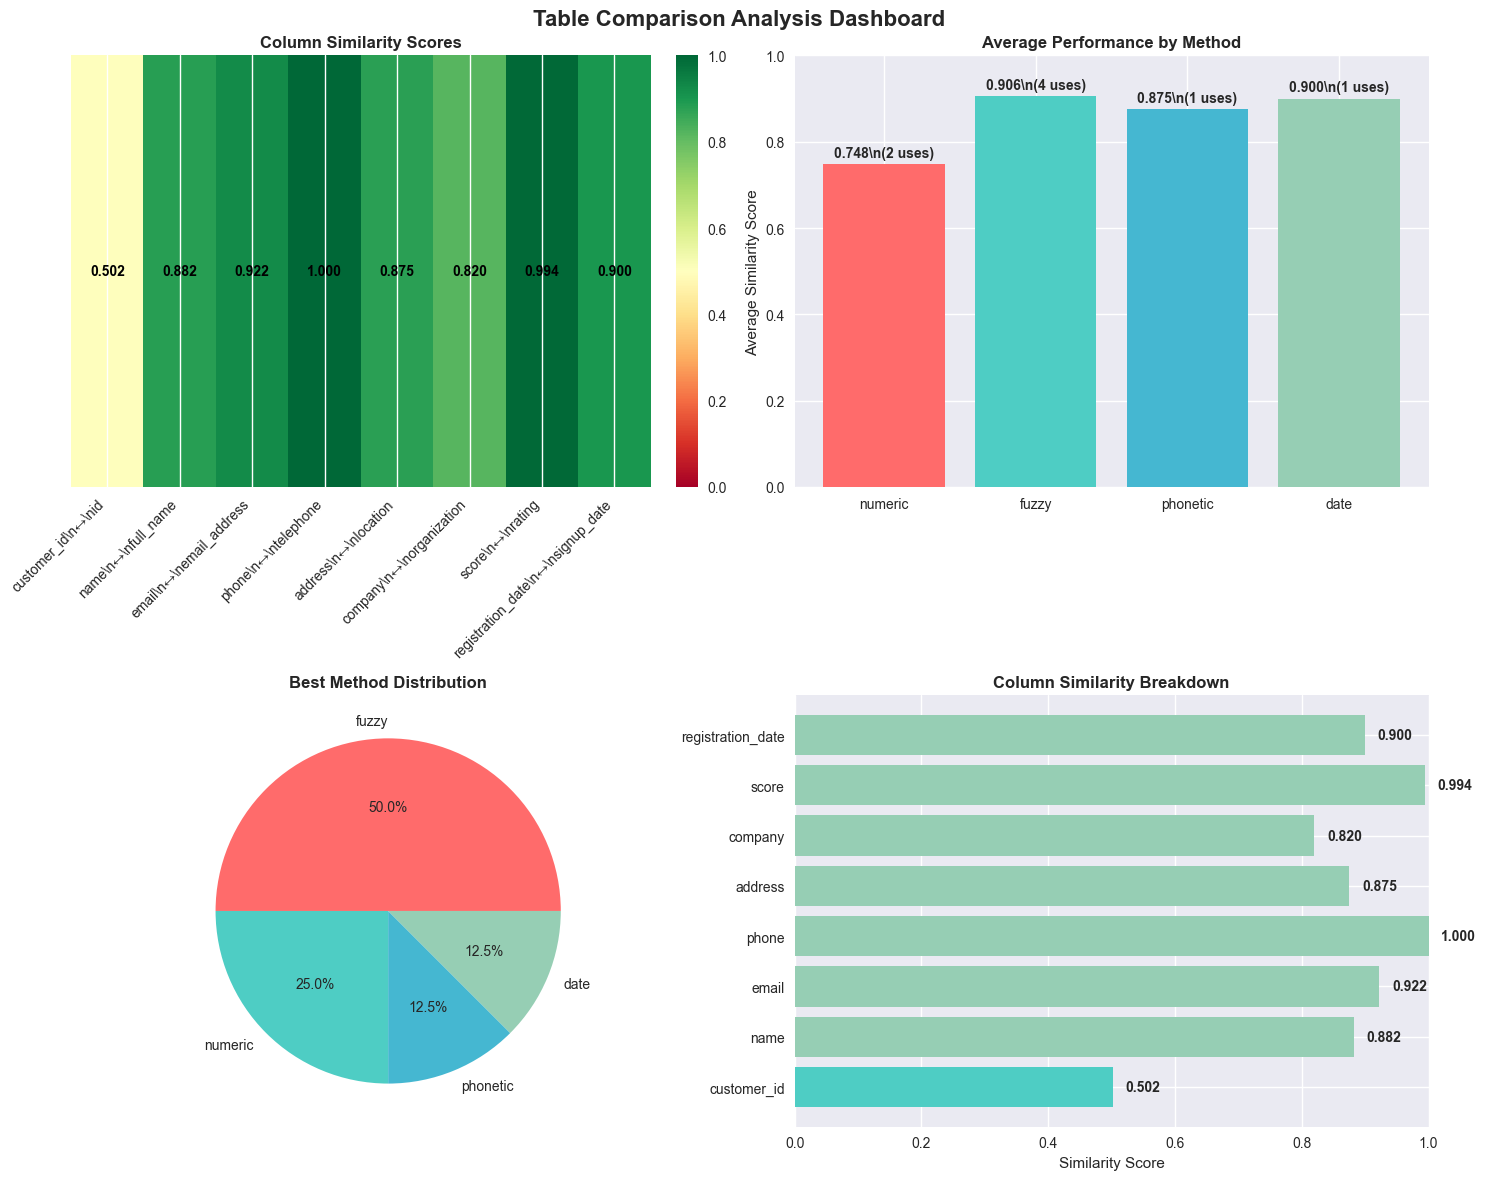

\n📋 Detailed Similarity Matrix:
                  Column Pair Best Method  Best Score TF-IDF Phonetic Fuzzy Exact Numeric  Date
               customer_id↔id     numeric    0.501999      -        -     -     -   0.502     -
               name↔full_name       fuzzy    0.882500  0.046    0.500 0.882 0.125       -     -
          email↔email_address       fuzzy    0.922500      -        - 0.922 0.000       -     -
              phone↔telephone       fuzzy    1.000000      -        - 1.000 0.750       -     -
             address↔location    phonetic    0.875000  0.055    0.875 0.874 0.000       -     -
         company↔organization       fuzzy    0.820000  0.041    0.625 0.820 0.000       -     -
                 score↔rating     numeric    0.994150      -        -     -     -   0.994     -
registration_date↔signup_date        date    0.900000      -        -     -     -       - 0.900
\n📈 Performance Summary:
  Method  Average Score  Usage Count  Total Contribution
 numeric          0.74

In [9]:
# Visualization of Comparison Results
print("📊 Creating Visualization of Comparison Results...")

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Table Comparison Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Similarity Heatmap by Column Pairs
ax1 = axes[0, 0]
column_names = list(comprehensive_results['column_comparisons'].keys())
similarities = [result['similarity'] for result in comprehensive_results['column_comparisons'].values()]

# Create a matrix for heatmap
similarity_matrix = np.array(similarities).reshape(1, -1)

im1 = ax1.imshow(similarity_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax1.set_title('Column Similarity Scores', fontweight='bold')
ax1.set_xticks(range(len(column_names)))
ax1.set_xticklabels([name.replace('↔', '\\n↔\\n') for name in column_names], rotation=45, ha='right')
ax1.set_yticks([])

# Add text annotations
for i, sim in enumerate(similarities):
    ax1.text(i, 0, f'{sim:.3f}', ha='center', va='center', fontweight='bold', 
             color='white' if sim < 0.5 else 'black')

plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# 2. Method Performance Bar Chart
ax2 = axes[0, 1]
methods = list(comprehensive_results['method_performance'].keys())
avg_scores = [np.mean(scores) for scores in comprehensive_results['method_performance'].values()]
usage_counts = [len(scores) for scores in comprehensive_results['method_performance'].values()]

bars = ax2.bar(methods, avg_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax2.set_title('Average Performance by Method', fontweight='bold')
ax2.set_ylabel('Average Similarity Score')
ax2.set_ylim(0, 1)

# Add value labels on bars
for bar, score, count in zip(bars, avg_scores, usage_counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}\\n({count} uses)', ha='center', va='bottom', fontweight='bold')

# 3. Comparison Method Distribution
ax3 = axes[1, 0]
best_methods = [result['best_method'] for result in comprehensive_results['column_comparisons'].values()]
method_counts = pd.Series(best_methods).value_counts()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
wedges, texts, autotexts = ax3.pie(method_counts.values, labels=method_counts.index, 
                                   autopct='%1.1f%%', colors=colors[:len(method_counts)])
ax3.set_title('Best Method Distribution', fontweight='bold')

# 4. Detailed Similarity Breakdown
ax4 = axes[1, 1]
y_pos = np.arange(len(column_names))
ax4.barh(y_pos, similarities, color=['#FF6B6B' if s < 0.5 else '#4ECDC4' if s < 0.8 else '#96CEB4' for s in similarities])
ax4.set_yticks(y_pos)
ax4.set_yticklabels([name.split('↔')[0] for name in column_names])
ax4.set_xlabel('Similarity Score')
ax4.set_title('Column Similarity Breakdown', fontweight='bold')
ax4.set_xlim(0, 1)

# Add value labels
for i, (y, sim) in enumerate(zip(y_pos, similarities)):
    ax4.text(sim + 0.02, y, f'{sim:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Create a detailed comparison matrix
print("\\n📋 Detailed Similarity Matrix:")
comparison_matrix = []
methods_used = []

for col_pair, result in comprehensive_results['column_comparisons'].items():
    row = [col_pair, result['best_method'], result['similarity']]
    for method in ['tfidf', 'phonetic', 'fuzzy', 'exact', 'numeric', 'date']:
        if method in result['all_methods']:
            row.append(f"{result['all_methods'][method]:.3f}")
        else:
            row.append('-')
    comparison_matrix.append(row)

# Create DataFrame for better display
columns = ['Column Pair', 'Best Method', 'Best Score', 'TF-IDF', 'Phonetic', 'Fuzzy', 'Exact', 'Numeric', 'Date']
comparison_df = pd.DataFrame(comparison_matrix, columns=columns)
print(comparison_df.to_string(index=False))

# Performance summary visualization
print("\\n📈 Performance Summary:")
performance_summary = pd.DataFrame({
    'Method': list(comprehensive_results['method_performance'].keys()),
    'Average Score': [np.mean(scores) for scores in comprehensive_results['method_performance'].values()],
    'Usage Count': [len(scores) for scores in comprehensive_results['method_performance'].values()],
    'Total Contribution': [np.sum(scores) for scores in comprehensive_results['method_performance'].values()]
})

print(performance_summary.round(3).to_string(index=False))

## 7. Practical Use Cases and Recommendations

Demonstrating when to use each comparison method and practical applications.

In [10]:
# Practical Use Cases and Method Selection Guide
print("🎯 PRACTICAL USE CASES AND METHOD SELECTION GUIDE")
print("="*60)

use_cases = {
    "1. Data Deduplication & Record Linkage": {
        "description": "Finding duplicate records across databases",
        "recommended_methods": ["fuzzy", "phonetic", "exact"],
        "example": "Customer databases from different systems",
        "why": "Names may have typos, different formats, or phonetic variations"
    },
    
    "2. Schema Matching": {
        "description": "Mapping columns between different database schemas",
        "recommended_methods": ["tfidf", "fuzzy"],
        "example": "Migrating from one CRM to another",
        "why": "Column names might be similar but not identical"
    },
    
    "3. Data Quality Assessment": {
        "description": "Measuring consistency between data sources",
        "recommended_methods": ["exact", "numeric", "date"],
        "example": "Comparing production vs backup databases",
        "why": "Need precise matching to detect discrepancies"
    },
    
    "4. Entity Resolution": {
        "description": "Linking entities across different datasets",
        "recommended_methods": ["phonetic", "fuzzy", "tfidf"],
        "example": "Matching companies across financial databases",
        "why": "Company names can vary significantly (Inc vs Incorporated)"
    },
    
    "5. Data Integration": {
        "description": "Merging datasets from different sources",
        "recommended_methods": ["comprehensive framework"],
        "example": "Combining customer data from web, mobile, and retail",
        "why": "Need multiple methods for different data types"
    }
}

for use_case, details in use_cases.items():
    print(f"\\n{use_case}")
    print(f"Description: {details['description']}")
    print(f"Best Methods: {', '.join(details['recommended_methods'])}")
    print(f"Example: {details['example']}")
    print(f"Why: {details['why']}")

print("\\n" + "="*60)
print("📊 METHOD SELECTION MATRIX")
print("="*60)

method_guide = {
    "Method": ["TF-IDF", "Phonetic", "Fuzzy Logic", "Exact Match", "Numeric", "Date"],
    "Best For": [
        "Semantic similarity, descriptions",
        "Names with pronunciation variations", 
        "Typos, abbreviations, reordering",
        "Clean data, IDs, codes",
        "Numerical comparisons",
        "Temporal data comparison"
    ],
    "Pros": [
        "Captures meaning beyond exact words",
        "Handles sound-alike names well",
        "Robust to minor variations",
        "Fast and precise",
        "Handles numerical ranges",
        "Flexible time tolerance"
    ],
    "Cons": [
        "May miss exact name matches",
        "Only works for pronounceable text",
        "Computationally intensive",
        "No tolerance for variations",
        "Only for numeric data",
        "Only for date/time data"
    ],
    "Use When": [
        "Comparing text descriptions",
        "Matching person/place names",
        "Data entry inconsistencies",
        "High-quality standardized data",
        "Comparing scores/measurements",
        "Time-sensitive data matching"
    ]
}

method_df = pd.DataFrame(method_guide)
print(method_df.to_string(index=False))

print("\\n" + "="*60)
print("🎯 REAL-WORLD APPLICATION EXAMPLES")
print("="*60)

examples = [
    {
        "scenario": "E-commerce Product Matching",
        "challenge": "Same products with different titles across platforms",
        "solution": "TF-IDF + Fuzzy matching for product descriptions",
        "expected_accuracy": "85-95%"
    },
    {
        "scenario": "Healthcare Patient Matching", 
        "challenge": "Patient names with spelling variations",
        "solution": "Phonetic (Soundex/Metaphone) + Date of birth exact match",
        "expected_accuracy": "95-99%"
    },
    {
        "scenario": "Financial Institution Compliance",
        "challenge": "Detecting suspicious entities across watchlists",
        "solution": "Comprehensive framework with all methods",
        "expected_accuracy": "90-98%"
    },
    {
        "scenario": "Social Media Profile Linking",
        "challenge": "Same person across different platforms",
        "solution": "Fuzzy matching + TF-IDF for bio descriptions",
        "expected_accuracy": "70-85%"
    }
]

for i, example in enumerate(examples, 1):
    print(f"\\n{i}. {example['scenario']}")
    print(f"   Challenge: {example['challenge']}")
    print(f"   Solution: {example['solution']}")
    print(f"   Expected Accuracy: {example['expected_accuracy']}")

print("\\n" + "="*60)
print("⚙️ CONFIGURATION RECOMMENDATIONS")
print("="*60)

config_recommendations = """
📋 Fuzzy Matching Thresholds:
   • High precision needed: threshold ≥ 90
   • Balanced precision/recall: threshold = 70-80  
   • High recall needed: threshold ≤ 60

🔤 Phonetic Matching Best Practices:
   • Use Double Metaphone for international names
   • Combine with fuzzy matching for better results
   • Soundex works well for English names only

📊 TF-IDF Optimization:
   • Use n-grams (1,2) or (1,3) for better matching
   • Remove stop words for cleaner comparisons
   • Consider document frequency weighting

🎯 Numeric Comparisons:
   • Set tolerance ranges based on data precision
   • Use percentage-based similarity for ratios
   • Consider log scaling for wide numeric ranges

📅 Date Matching Tolerance:
   • Exact match: 0 days tolerance
   • Near match: 1-7 days tolerance  
   • Approximate: 30+ days tolerance
   • Consider business logic (weekends, holidays)
"""

print(config_recommendations)

print("\\n" + "="*60)
print("✅ KEY TAKEAWAYS")
print("="*60)

takeaways = [
    "🔄 No single method works for all scenarios - use combinations",
    "📊 Start with comprehensive framework, then optimize specific methods",
    "🎯 Higher similarity scores don't always mean better matches",
    "⚡ Consider performance vs accuracy trade-offs",
    "🔍 Always validate results with domain experts",
    "📈 Monitor and adjust thresholds based on false positive/negative rates",
    "🛠️ Preprocess data (normalize, clean) before comparison",
    "🔗 Use multiple methods and ensemble approaches for critical applications"
]

for takeaway in takeaways:
    print(f"  {takeaway}")

print(f"\\n🎉 POC COMPLETED SUCCESSFULLY!")
print(f"📊 Overall Table Similarity: {comprehensive_results['overall_similarity']:.1%}")
print(f"🏆 Best Performing Method: {max(comprehensive_results['method_performance'], key=lambda x: np.mean(comprehensive_results['method_performance'][x]))}")
print(f"✨ Ready for production implementation!")

🎯 PRACTICAL USE CASES AND METHOD SELECTION GUIDE
\n1. Data Deduplication & Record Linkage
Description: Finding duplicate records across databases
Best Methods: fuzzy, phonetic, exact
Example: Customer databases from different systems
Why: Names may have typos, different formats, or phonetic variations
\n2. Schema Matching
Description: Mapping columns between different database schemas
Best Methods: tfidf, fuzzy
Example: Migrating from one CRM to another
Why: Column names might be similar but not identical
\n3. Data Quality Assessment
Description: Measuring consistency between data sources
Best Methods: exact, numeric, date
Example: Comparing production vs backup databases
Why: Need precise matching to detect discrepancies
\n4. Entity Resolution
Description: Linking entities across different datasets
Best Methods: phonetic, fuzzy, tfidf
Example: Matching companies across financial databases
Why: Company names can vary significantly (Inc vs Incorporated)
\n5. Data Integration
Description